### Import TensorFlow and other libraries

In [1]:
import tensorflow as tf
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
from IPython import display
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

2022-07-04 11:36:52.105989: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Load and prepare the dataset


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-07-04 11:37:01.555184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-04 11:37:02.256167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14254 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:b2:00.0, compute capability: 8.6


In [6]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Create the models


### The Generator

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model

In [8]:
generator = make_generator_model()

In [9]:
generator = tf.keras.models.load_model('saved_model/generator')

2022-07-04 11:37:04.407966: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-07-04 11:37:04.611675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-07-04 11:37:06.380530: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-07-04 11:37:06.382650: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-07-04 11:37:06.382663: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-07-04 11:37:06.382713: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED:

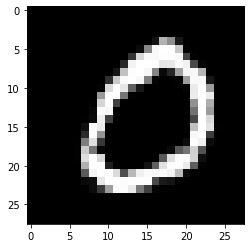

In [10]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [12]:
discriminator = make_discriminator_model()

In [13]:
discriminator = tf.keras.models.load_model('saved_model/discriminator')

In [14]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.53193045]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
loss = mse

### Discriminator loss

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss(tf.ones_like(real_output), real_output)
    fake_loss = loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

In [17]:
def generator_loss(fake_output):
    return loss(tf.ones_like(fake_output), fake_output)

### Optimizers

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define the training loop

In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
def my_numpy_func(x):
      return x
    
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return tf.numpy_function(my_numpy_func, [gen_loss], tf.float32), tf.numpy_function(my_numpy_func, [disc_loss], tf.float32)

In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        display.clear_output(wait=True)
        gen_loss_mean = 0.0
        disc_loss_mean = 0.0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_mean += float(gen_loss)
            disc_loss_mean += float(disc_loss)
        gen_loss_mean /= len(dataset)
        disc_loss_mean /= len(dataset)
        generate_and_save_images(generator, epoch + 1, seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print ('Loss for generator is {}'.format(gen_loss_mean))
        print ('Loss for discriminator is {}'.format(disc_loss_mean))

In [29]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.suptitle('Epoch %d'%epoch)
    plt.savefig('plots/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the model

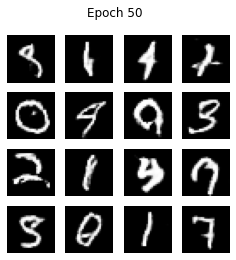

Time for epoch 50 is 4.73880934715271 sec
Loss for generator is 0.3362829877975139
Loss for discriminator is 0.45103821386682225


In [30]:
train(train_dataset, EPOCHS)

## Create a GIF

In [32]:
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('plots/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

/tmp/ipykernel_4074602/205529226.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_4074602/205529226.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



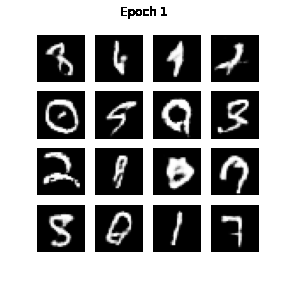

In [33]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Save model

In [26]:
generator.save('saved_model/generator')
discriminator.save('saved_model/discriminator')

INFO:tensorflow:Assets written to: saved_model/generator/assets


INFO:tensorflow:Assets written to: saved_model/generator/assets


INFO:tensorflow:Assets written to: saved_model/discriminator/assets


INFO:tensorflow:Assets written to: saved_model/discriminator/assets
